<a href="https://colab.research.google.com/github/athens-igg/image_classsifier/blob/main/image_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

(np.float64(-0.5), np.float64(165.5), np.float64(165.5), np.float64(-0.5))

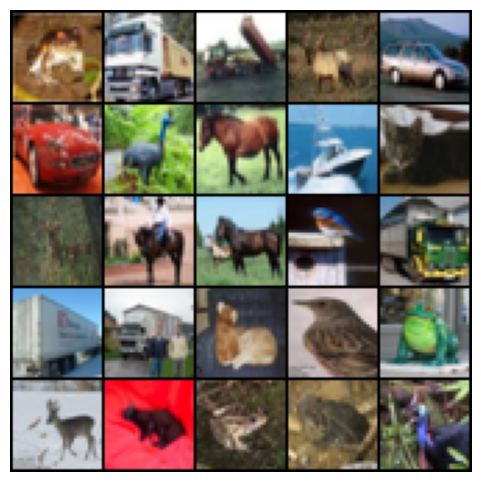

In [ ]:
import torch
import torchvision
import matplotlib.pyplot as plt
import numpy as np

# The below two lines are optional and are just there to avoid any SSL
# related errors while downloading the CIFAR-10 dataset
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

#Defining plotting settings
plt.rcParams['figure.figsize'] = 14, 6

#Initializing normalizing transform for the dataset
normalize_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean = (0.5, 0.5, 0.5),
                                     std = (0.5, 0.5, 0.5))])

#Downloading the CIFAR10 dataset into train and test sets
train_dataset = torchvision.datasets.CIFAR10(
    root="./CIFAR10/train", train=True,
    transform=normalize_transform,
    download=True)

test_dataset = torchvision.datasets.CIFAR10(
    root="./CIFAR10/test", train=False,
    transform=normalize_transform,
    download=True)

#Generating data loaders from the corresponding datasets
batch_size = 128
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

#Plotting 25 images from the 1st batch
dataiter = iter(train_loader)
images, labels = next(dataiter)
plt.imshow(np.transpose(torchvision.utils.make_grid(
  images[:25], normalize=True, padding=1, nrow=5).numpy(), (1, 2, 0)))
plt.axis('off')

Text(0, 0.5, 'Number of training instances')

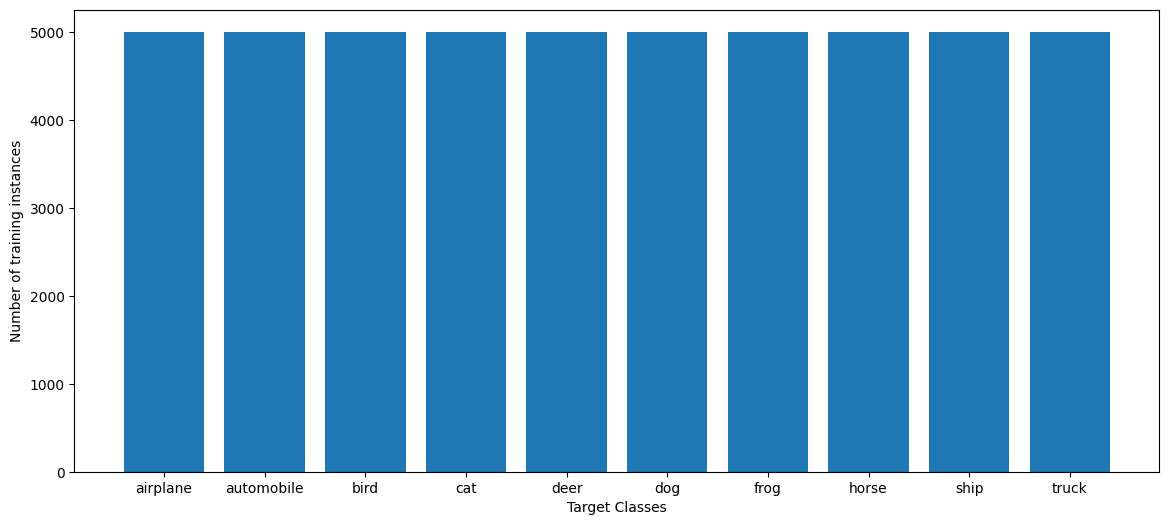

In [ ]:
#Iterating over the training dataset and storing the target class for each sample
classes = []
for batch_idx, data in enumerate(train_loader, 0):
    x, y = data
    classes.extend(y.tolist())

#Calculating the unique classes and the respective counts and plotting them
unique, counts = np.unique(classes, return_counts=True)
names = list(test_dataset.class_to_idx.keys())
plt.bar(names, counts)
plt.xlabel("Target Classes")
plt.ylabel("Number of training instances")

In [ ]:
class CNN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.model = torch.nn.Sequential(
            #Input = 3 x 32 x 32, Output = 32 x 32 x 32
            torch.nn.Conv2d(in_channels = 3, out_channels = 32, kernel_size = 3, padding = 1),
            torch.nn.ReLU(),
            #Input = 32 x 32 x 32, Output = 32 x 16 x 16
            torch.nn.MaxPool2d(kernel_size=2),

            #Input = 32 x 16 x 16, Output = 64 x 16 x 16
            torch.nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 3, padding = 1),
            torch.nn.ReLU(),
            #Input = 64 x 16 x 16, Output = 64 x 8 x 8
            torch.nn.MaxPool2d(kernel_size=2),

            #Input = 64 x 8 x 8, Output = 64 x 8 x 8
            torch.nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size = 3, padding = 1),
            torch.nn.ReLU(),
            #Input = 64 x 8 x 8, Output = 64 x 4 x 4
            torch.nn.MaxPool2d(kernel_size=2),

            torch.nn.Flatten(),
            torch.nn.Linear(64*4*4, 512),
            torch.nn.ReLU(),
            torch.nn.Linear(512, 10)
        )

    def forward(self, x):
        return self.model(x)

Epoch 1/5: Training loss = 1.6400169301825716
Epoch 2/5: Training loss = 1.3638547783922357
Epoch 3/5: Training loss = 1.2585157845026391
Epoch 4/5: Training loss = 1.1766555856560807
Epoch 5/5: Training loss = 1.108176280622897


Text(0, 0.5, 'Training loss')

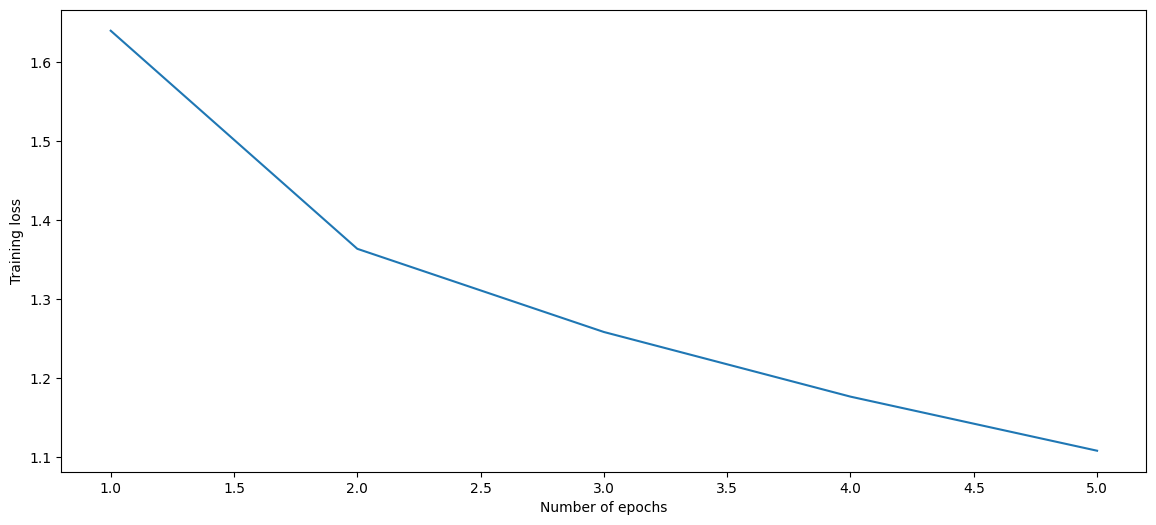

In [ ]:
#Selecting the appropriate training device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = CNN().to(device)

#Defining the model hyper parameters
num_epochs = 5
learning_rate = 0.001
weight_decay = 0.01
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

#Training process begins
train_loss_list = []
for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}/{num_epochs}:', end = ' ')
    train_loss = 0

    #Iterating over the training dataset in batches
    model.train()
    for i, (images, labels) in enumerate(train_loader):

        #Extracting images and target labels for the batch being iterated
        images = images.to(device)
        labels = labels.to(device)

        #Calculating the model output and the cross entropy loss
        outputs = model(images)
        loss = criterion(outputs, labels)

        #Updating weights according to calculated loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    #Printing loss for each epoch
    train_loss_list.append(train_loss/len(train_loader))
    print(f"Training loss = {train_loss_list[-1]}")

#Plotting loss for all epochs
plt.plot(range(1,num_epochs+1), train_loss_list)
plt.xlabel("Number of epochs")
plt.ylabel("Training loss")

In [ ]:
torch.cuda.is_available()


False

In [14]:
test_acc=0
model.eval()

with torch.no_grad():
    #Iterating over the training dataset in batches
    for i, (images, labels) in enumerate(test_loader):

        images = images.to(device)
        y_true = labels.to(device)

        #Calculating outputs for the batch being iterated
        outputs = model(images)

        #Calculated prediction labels from models
        _, y_pred = torch.max(outputs.data, 1)

        #Comparing predicted and true labels
        test_acc += (y_pred == y_true).sum().item()

    print(f"Test set accuracy = {100 * test_acc / len(test_dataset)} %")

Test set accuracy = 62.94 %


(np.float64(-0.5), np.float64(66.5), np.float64(33.5), np.float64(-0.5))

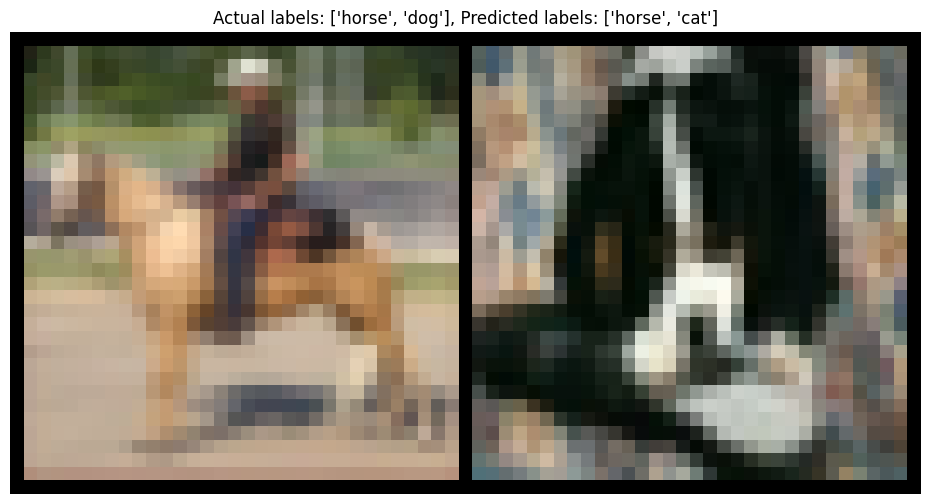

In [15]:
#Generating predictions for 'num_images' amount of images from the last batch of test set
num_images = 2
y_true_name = [names[y_true[idx]] for idx in range(num_images)]
y_pred_name = [names[y_pred[idx]] for idx in range(num_images)]

#Generating the title for the plot
title = f"Actual labels: {y_true_name}, Predicted labels: {y_pred_name}"

#Finally plotting the images with their actual and predicted labels in the title
plt.imshow(np.transpose(torchvision.utils.make_grid(images[:num_images].cpu(), normalize=True, padding=1).numpy(), (1, 2, 0)))
plt.title(title)
plt.axis("off")